# <font color="orange">Load modules</font> 

In [31]:
import cv2
import sklearn.ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import datasets, layers, models
import sys
sys.path.append("/Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244")
from _CFG_Task_B import *
from _CLASS_ImageManager import *

In the following lines we load the labels .csv file.

In [32]:
y = load_images_label_csv("eye_color")

The following code is to remove the test_set in case this has been moved from cartoon_set_test/img to cartoon_set/img.

In [33]:
if count_n_images(sub_folder, extension) > 10000:
    move_images_fromfolder(sub_folder, sub_test_folder, extension)

# <font color="orange">Load and process images</font> 

We leverage on the **ImageManager** class object to load the whole set of images as well as crop them based on the body part we are interested in. The processing is based on a Haar Cascade Classifier. This is an effective object detection approach which was proposed by Paul Viola and Michael Jones back in 2001. This is basically a machine learning based approach where a cascade function is trained from a lot of images both positive and negative. Based on the training it is then used to detect the objects in the other images.
So how this works is they are huge individual .xml files with a lot of feature sets and each .xml corresponds to a very specific type of use case.

In [34]:
imgmgr = ImageManager()
imgmgr.load_images_from_folder(sub_folder, extension, verbose = True)
imgmgr.bodypart = "eyes"
imges = imgmgr.crop_part((16,16), squaring=False, x_offsets=(1/3,-1/4), y_offsets = (1/4,-1/4))

Starting to load images from /Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244/Datasets/cartoon_set/img/ with extension .png
921/10000 images loaded
1684/10000 images loaded
2483/10000 images loaded
3253/10000 images loaded
3919/10000 images loaded
4623/10000 images loaded
5299/10000 images loaded
5997/10000 images loaded
6686/10000 images loaded
7465/10000 images loaded
8184/10000 images loaded
8957/10000 images loaded
9720/10000 images loaded
10000/10000 images loaded


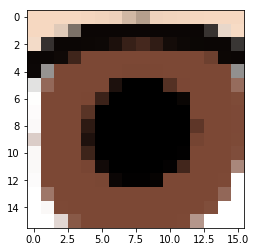

In [35]:
rgb = cv2.cvtColor(imges[4], cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

# <font color="orange">Solving exercise using various machine learning approches</font> 

Once our images have been processed, we can split our dataset into train and test sets.

In [36]:
X = imgmgr.images
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_train, X_test, y_train, y_test = train_test_split(X,y)

### 1. K-Nearest Neighbors

In [37]:
clf = KNeighborsClassifier(10, p=2, weights="uniform")
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1522
           1       0.88      0.86      0.87      1487
           2       0.84      0.86      0.85      1450
           3       0.87      0.85      0.86      1504
           4       0.89      0.84      0.87      1537

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500

TEST METRICS
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       482
           1       0.82      0.82      0.82       531
           2       0.79      0.77      0.78       519
           3       0.79      0.80      0.79       488
           4       0.88      0.79      0.83       480

    accuracy                           0.80      2500
   macro avg       0.81      0.80      0.80      2500
weighted avg       0.81      0.80      0.80      2

We present the confusion matrix once data has been trained using KNN.

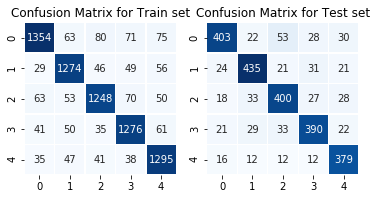

In [38]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

So far we have performed a KNN algorithm on our train and test set with K=10. This returns a good accuracy. Now we want to check if there are actually other Ks which would lead to better results. Added to this, we will perform a cross-validation on the entire dataset. For example, for 3-fold cross validation, the dataset would be split into 3 groups, and the model would be trained and tested 3 separate times so each group would get a chance to be the test set.

In [ ]:
k_range = np.arange(1, 31, 5)
k_scores = []

# use iteration to calculate accuracy on different k in models, then return the average accuracy based on the cross validation.
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=3, scoring='accuracy')
    k_scores.append(scores.mean())

In [ ]:
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-Validated Accuracy')
plt.legend(loc="upper right")
plt.title('Backtesting performance of KNN')
plt.show()

### 2. Random Forest

In [ ]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=60, criterion="entropy", max_depth=10)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

In [ ]:
n_estimators=np.arange(5, 100, 5)

# Dictionary containing (<n_estimators>, <error rate>) pairs.
d = {}

for x in n_estimators:
    clf.set_params(n_estimators=x)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    d[x] = error

plt.plot(d.keys(), d.values())
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title('Backtesting performance of number of trees')
plt.show()

We present the confusion matrix once data has been trained using Random Forest.

In [ ]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

Now we perform some hyper-parameter tuning to see if other Random Forest arguments would have led to a significantly higher performance. The below dictionary will test 4 different sizes of n_estimators and max_depth. We have initialised this process as we initially observed that allowing a flexible "max_depth" variable would lead to overfitting.

In [ ]:
param_grid = {"n_estimators": [20, 40, 60, 80],
              "max_depth":    [5, 7, 10, 20]}

In [ ]:
grid_clf = sklearn.model_selection.GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

In [ ]:
results_table = pd.DataFrame.from_dict(grid_clf.cv_results_).set_index("rank_test_score")
results_table